# Analytical model

This is an analytical model to construct a simple SNR of a given spectrum.

In [1]:
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import pandas as pd
import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
import os
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
par.hdr
from scipy.interpolate import interp1d
import pandas as pd
from astropy.table import Table,QTable
from crispy.tools.detutils import rebin
from scipy import ndimage
from IPython.display import display


Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as n
import scipy.interpolate
import scipy.ndimage

def congrid(a, newdims, method='linear', centre=False, minusone=False):
    '''Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).
    
    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL''s congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    '''
    if not a.dtype in [n.float64, n.float32]:
        a = n.cast[float](a)

    m1 = n.cast[int](minusone)
    ofs = n.cast[int](centre) * 0.5
    old = n.array( a.shape )
    ndims = len( a.shape )
    if len( newdims ) != ndims:
        print "[congrid] dimensions error. " \
              "This routine currently only support " \
              "rebinning to the same number of dimensions."
        return None
    newdims = n.asarray( newdims, dtype=float )
    dimlist = []

    if method == 'neighbour':
        for i in range( ndims ):
            base = n.indices(newdims)[i]
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        cd = n.array( dimlist ).round().astype(int)
        newa = a[list( cd )]
        return newa

    elif method in ['nearest','linear']:
        # calculate new dims
        for i in range( ndims ):
            base = n.arange( newdims[i] )
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        # specify old dims
        olddims = [n.arange(i, dtype = n.float) for i in list( a.shape )]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d( olddims[-1], a, kind=method )
        newa = mint( dimlist[-1] )

        trorder = [ndims - 1] + range( ndims - 1 )
        for i in range( ndims - 2, -1, -1 ):
            newa = newa.transpose( trorder )

            mint = scipy.interpolate.interp1d( olddims[i], newa, kind=method )
            newa = mint( dimlist[i] )

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose( trorder )

        return newa
    elif method in ['spline']:
        oslices = [ slice(0,j) for j in old ]
        oldcoords = n.ogrid[oslices]
        nslices = [ slice(0,j) for j in list(newdims) ]
        newcoords = n.mgrid[nslices]

        newcoords_dims = range(n.rank(newcoords))
        #make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs

        deltas = (n.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print "Congrid error: Unrecognized interpolation type.\n", \
              "Currently only \'neighbour\', \'nearest\',\'linear\',", \
              "and \'spline\' are supported."
        return None

def frebin(array, shape, total=True):
    """
    Function that performs flux-conservative
    rebinning of an array. Found at https://github.com/benjaminpope/pysco/blob/master/frebin.py


    Parameters
    ----------
    array: ndarray
        Numpy array to be rebinned
    shape: tuple
        (x,y) of new array size
        total: Boolean
            when True flux is conserved
    Returns
    -------
        new_array: new rebinned array with dimensions: shape
    """

    # Determine size of input image
    y, x = array.shape

    y1 = y - 1
    x1 = x - 1

    xbox = x / float(shape[0])
    ybox = y / float(shape[1])

    # Determine if integral contraction so we can use rebin
    if (x == int(x)) and (y == int(y)):
        if (x % shape[0] == 0) and (y % shape[1] == 0):
            return rebin(array, (shape[1], shape[0])) * xbox * ybox

    # Otherwise if not integral contraction
    # First bin in y dimension
    temp = np.zeros((shape[1], x), dtype=float)
    # Loop on output image lines
    for i in range(0, int(shape[1]), 1):
        rstart = i * ybox
        istart = int(rstart)
        rstop = rstart + ybox
        istop = int(rstop)
        if istop > y1:
            istop = y1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)

    # Add pixel values from istart to istop an subtract
    # fracion pixel from istart to rstart and fraction
    # fraction pixel from rstop to istop.
        if istart == istop:
            temp[i, :] = (1.0 - frac1 - frac2) * array[istart, :]
        else:
            temp[i, :] = np.sum(array[istart:istop + 1, :], axis=0)\
                - frac1 * array[istart, :]\
                - frac2 * array[istop, :]

    temp = np.transpose(temp)

    # Bin in x dimension
    result = np.zeros((shape[0], shape[1]), dtype=float)
    # Loop on output image samples
    for i in range(0, int(shape[0]), 1):
        rstart = i * xbox
        istart = int(rstart)
        rstop = rstart + xbox
        istop = int(rstop)
        if istop > x1:
            istop = x1
        frac1 = rstart - istart
        frac2 = 1.0 - (rstop - istop)
    # Add pixel values from istart to istop an subtract
    # fracion pixel from istart to rstart and fraction
    # fraction pixel from rstop to istop.
        if istart == istop:
            result[i, :] = (1. - frac1 - frac2) * temp[istart, :]
        else:
            result[i, :] = np.sum(temp[istart:istop + 1, :], axis=0)\
                - frac1 * temp[istart, :]\
                - frac2 * temp[istop, :]

    if total:
        return np.transpose(result)
    elif not total:
        return np.transpose(result) / float(xbox * ybox)



In [3]:
a = np.arange(100)
b = congrid(a,[10])
print b

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90.]


In [4]:
def IFSModel(datafile,
             minlam=700*u.nm,
             maxlam=841*u.nm,
             Vmag = 4.83,
             R=50,
             QEfile=None,
             QELosses = 0.9*0.97*0.9*0.78, # losses on top of QE
             verbose=True,
             cic=2e-2*u.ct, # CIC
             dark = 2.24e-4*u.ct/u.s, # dark current
             zodi = 7.6e-4*u.ct/u.s, # total zodiacal contribution
             CFcontrast = 2.6e-9,
             I_pk = 1.4e-3,
             mpix=24, # Noise equivalent pixels
             nbins=None,
             cgi_mpix=32, # used for speckle estimates (will ask Bijan)
             sp_tau = 0.34, # speckle throughput
             tau=0.0116, # planet throughput
             A = 3.68*u.m**2, # aperture size
             mult=1.32,
             fpp=0.1,
             obstime=240*3600*u.s,
             ftime = 100*u.s, # frame exposure time
             forceSNR=None,#10,
             ntrials = 1000,
            ):
    # load QE
    loadQE = np.loadtxt(QEfile)
    QE = interp1d(loadQE[:,0]/1000,loadQE[:,1])
    
    # Load Sergi's table
    table = pd.read_table(datafile,
                     names=('wavelength','albedo','contrast','star','flux'),
                     delimiter=',')
    if verbose:
        plt.figure()
        plt.plot(table['wavelength'],table['albedo'])
        plt.title('Albedo')
        plt.xlabel('Wavelength  (um)')
        plt.ylabel('Albedo')
        
    # load stellar spectra
    fname = par.codeRoot+'/Inputs/ETC/Spectra.csv'
    st = pd.read_csv(fname,skip_blank_lines=True,)
    stars = QTable.from_pandas(st)
    stars['Wavelength (m) '].unit = u.m
    stars.rename_column('Wavelength (m) ', 'Wavelength')
    stars['E_ph (J)'].unit = u.J/u.ph
    stars.rename_column('E_ph (J)', 'E_ph')
    cols = ['a0v','a5v','f5v','g0v','g5v','k0v','k5v','m0v','m5v']
    for col in cols:
        stars[col].unit = u.W/u.m**2/u.m
    star_ph_flux = (stars['g0v']/stars['E_ph']*u.nm).to(u.ph/u.s/u.m**2)
    
    # Adjust for stellar magnitude
    star_ph_flux *= 10**(-0.4*Vmag)
    
    if verbose:
        plt.figure()
        plt.plot(stars['Wavelength'].to(u.um),star_ph_flux)
        plt.title('Stellar flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(star_ph_flux.unit))
        
    # Compute photons from planet
    # first, need to make sure both wavelength axes boundaries are compatible
    albedo = interp1d(table['wavelength'],table['contrast'])
    wl = stars['Wavelength'].to(u.um)
    star_ph_flux = star_ph_flux[wl.value>np.amin(table['wavelength'])]
    wl = wl[wl.value>np.amin(table['wavelength'])]
    star_ph_flux = star_ph_flux[wl.value<np.amax(table['wavelength'])]
    wl = wl[wl.value<np.amax(table['wavelength'])]
    # then we can multiply simply
    planet_ph_flux = star_ph_flux*albedo(wl)
    
    if verbose:
        plt.figure()
        plt.plot(wl,planet_ph_flux)
        plt.title('Planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))
       
    # Focus on IFS band
    wmax = maxlam.to(u.um).value
    wmin=minlam.to(u.um).value
    planet_ph_flux = planet_ph_flux[wl.value>wmin]
    star_ph_flux = star_ph_flux[wl.value>wmin]
    wl = wl[wl.value>wmin]
    planet_ph_flux = planet_ph_flux[wl.value<wmax]
    star_ph_flux = star_ph_flux[wl.value<wmax]
    wl = wl[wl.value<wmax]
    
    if verbose:
        plt.figure()
        plt.plot(wl,planet_ph_flux)
        plt.title('Planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))
        
    # convolve with IFS line spread function
    dlam = wl[1]-wl[0]
    midlam = 0.5*(maxlam.to(u.um).value+minlam.to(u.um).value)
    if nbins is None:
        Dlam = midlam/R
        FWHM = Dlam/dlam
        nbins = int(round((maxlam.to(u.um).value-minlam.to(u.um).value)/Dlam)+1)
    else:
        Dlam = (maxlam.to(u.um).value-minlam.to(u.um).value)/nbins
        FWHM = Dlam/dlam

    if verbose:
        print("FWHM is {:} original bins".format(FWHM.value))
        print("Number of IFS bins is {:}".format(nbins))
#     pl_ph_flux2 = ndimage.filters.gaussian_filter1d(planet_ph_flux,FWHM.value/2.35,order=0,mode='nearest')
#     pl_ph_flux = pl_ph_flux2.reshape(nbins,len(pl_ph_flux2)/nbins).sum(-1)*planet_ph_flux.unit
#     st_ph_flux2 = ndimage.filters.gaussian_filter1d(star_ph_flux,FWHM.value/2.35,order=0,mode='nearest')
#     st_ph_flux = st_ph_flux2.reshape(nbins,len(star_ph_flux)/nbins).sum(-1)*star_ph_flux.unit
    pl_ph_flux2 = ndimage.filters.gaussian_filter1d(planet_ph_flux,FWHM.value/2.35,order=0,mode='nearest')
    pl_ph_flux2 = pl_ph_flux2.reshape((len(pl_ph_flux2),1))
#     pl_ph_flux = congrid(pl_ph_flux2,newdims = [np.round(len(pl_ph_flux2)/nbins)])*planet_ph_flux.unit
    pl_ph_flux = np.reshape(frebin(pl_ph_flux2,(1,nbins)),-1)*planet_ph_flux.unit
    st_ph_flux2 = ndimage.filters.gaussian_filter1d(star_ph_flux,FWHM.value/2.35,order=0,mode='nearest')
    st_ph_flux2 = st_ph_flux2.reshape((len(st_ph_flux2),1))
#     st_ph_flux = congrid(st_ph_flux2,newdims = [np.round(len(st_ph_flux2)/nbins)])*planet_ph_flux.unit
    st_ph_flux = np.reshape(frebin(st_ph_flux2,(1,nbins)),-1)*planet_ph_flux.unit
    print len(st_ph_flux2)
#     w = wl.reshape(nbins,len(planet_ph_flux)/nbins).mean(-1)  
    w = congrid(wl,[nbins])*wl.unit
    
    if verbose:
        plt.figure()
        plt.plot(wl,pl_ph_flux2)
        plt.title('Convolved planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))
        plt.figure()
        plt.plot(w,pl_ph_flux)
        plt.title('Convolved and binned planet flux')
        plt.xlabel('Wavelength (um)')
        plt.ylabel(r'{:}'.format(planet_ph_flux.unit))

    # calculate rates
    pl_ph = pl_ph_flux*A*tau
    effQE = QE(w)*QELosses
    pl_e_rate = pl_ph*effQE*u.count/u.ph
    st_e_rate = st_ph_flux*A*effQE*u.count/u.ph
    speckle = st_e_rate*cgi_mpix*sp_tau*I_pk*CFcontrast
    phconv_rate = (zodi+speckle+pl_e_rate)
    perpxrate = dark+phconv_rate/mpix
    if verbose: print('Rate per pixel: {:}'.format(perpxrate))
        
    # determine contributions and SNR
    shotnoise = np.sqrt((pl_e_rate+mult*(speckle+zodi))*obstime)
    elecnoise = np.sqrt(mult*mpix*(dark+cic/ftime)*obstime)
    spnoise = fpp*speckle*obstime
    SNR = pl_e_rate*obstime/np.sqrt(shotnoise.value**2+elecnoise.value**2+spnoise.value**2)

    if verbose:
#         print('Signal counts: {:}'.format(pl_e_rate*obstime))
#         print('Shot noise: {:}'.format(shotnoise))
#         print('Detector noise: {:}'.format(elecnoise))
#         print('Speckle noise: {:}'.format(spnoise))
#         print('SNR: {:}'.format(SNR))
        df = pd.DataFrame({'Wavelength':w,
                           'Signal': pl_e_rate*obstime,
                           'Shot noise': shotnoise,
                           'Detector noise': elecnoise,
                           'Speckle noise': spnoise,
                           'Total noise': np.sqrt(shotnoise.value**2+elecnoise.value**2+spnoise.value**2),
                           'Signal': pl_e_rate*obstime,
                           'SNR': SNR,
                          })
        df.set_index('Wavelength')
        display(df[['Wavelength','Shot noise','Detector noise','Speckle noise','Total noise','Signal','SNR']])
    
    vals = albedo(w)
    
    N = len(SNR)
    if forceSNR is not None:
        SNRnorm = SNR.value*forceSNR/SNR[N/2].value
    else:
        SNRnorm = SNR.value
    output = np.random.normal(vals,vals/SNRnorm)

    if verbose:
        plt.figure()
        plt.errorbar(w.value,output,yerr=vals/SNRnorm,fmt='-o',label='Recovered albedo')
        plt.plot(w.value,vals,label='True albedo')
        plt.title('Recovered albedo')
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Albedo')
        plt.legend()
        
    if ntrials is not None:
        sim = np.zeros((N,ntrials))
        for i in range(ntrials):
            sim[:,i] = np.random.normal(vals,vals/SNRnorm)
        if verbose:
            plt.figure()
            plt.errorbar(w.value,sim[:,ntrials/2],yerr=np.std(sim,axis=1),fmt='-o',label='Recovered albedo')
            plt.plot(w.value,vals,label='True albedo')
            plt.fill_between(w.value,
                             np.mean(sim,axis=1)-np.mean(sim,axis=1)/SNRnorm,
                             np.mean(sim,axis=1)+np.mean(sim,axis=1)/SNRnorm,
                             alpha=0.3,label='Theoretical error bar')
            plt.title('Recovered albedo')
            plt.xlabel('Wavelength (um)')
            plt.ylabel('Albedo')
            plt.legend()
            output = sim
    return output

FWHM is 7.83333333333 original bins
Number of IFS bins is 18
140
Rate per pixel: [ 0.00037924  0.00037235  0.00036451  0.00036296  0.00036316  0.00036104
  0.00035556  0.00034205  0.00034885  0.00034469  0.00033966  0.00033567
  0.00033269  0.00033022  0.00032756  0.00032427  0.00031965  0.00031412] ct / s


,Wavelength,Shot noise,Detector noise,Speckle noise,Total noise,Signal,SNR
0,0.701000,60.079418,107.72894,56.341049,135.607429,1999.069846,14.741595
1,0.708778,58.800919,107.72894,53.533530,133.898885,1884.140634,14.071369
2,0.716556,57.335434,107.72894,51.102664,132.304039,1746.032081,13.197118
3,0.724333,57.053377,107.72894,51.105854,132.183284,1713.725765,12.964769
4,0.732111,57.069638,107.72894,50.342983,131.897248,1725.651400,13.083301
5,0.739889,56.625912,107.72894,48.351581,130.957603,1701.488225,12.992665
6,0.747667,55.534553,107.72894,45.604730,129.496728,1615.339324,12.473978
7,0.755444,52.769029,107.72894,39.547194,126.309443,1395.782697,11.050502
8,0.763222,54.186024,107.72894,42.851050,127.976022,1503.726534,11.750065
9,0.771000,53.334161,107.72894,41.159449,127.059661,1434.463178,11.289682


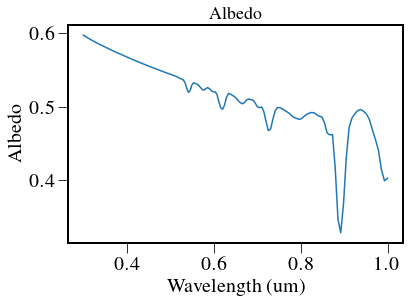

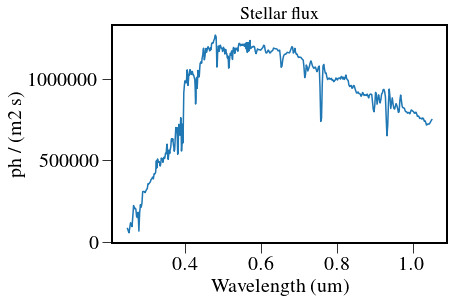

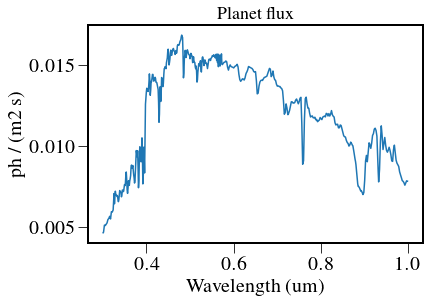

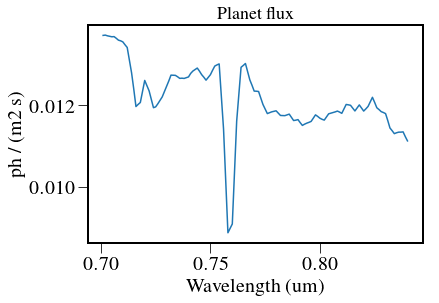

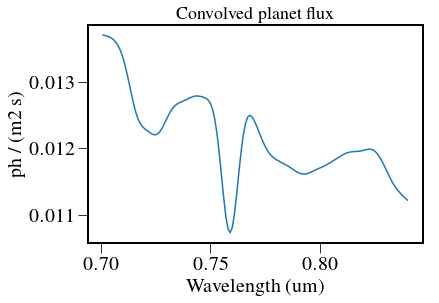

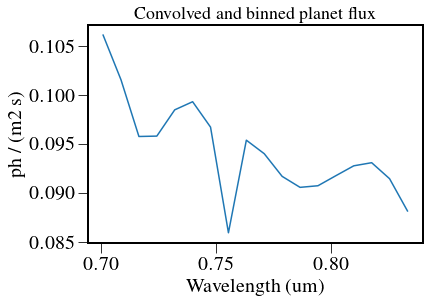

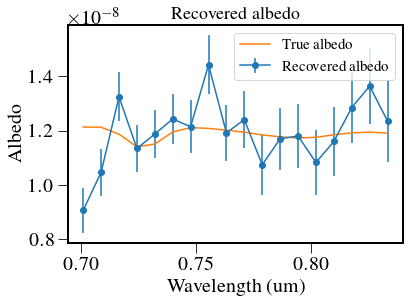

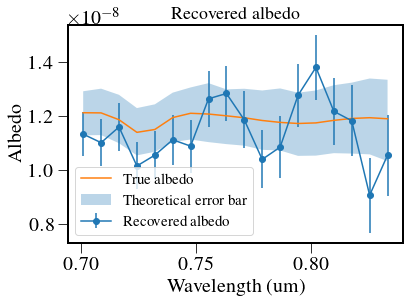

In [5]:
output = IFSModel(par.codeRoot+"/Inputs/LAS_spectra_for_exospec_bright_comparison_0deg_g0.0_EDC_012618_by_SRH.txt",
             minlam=700*u.nm,
             maxlam=841*u.nm,
             Vmag = 4.83,
             R=50,
             nbins=18,
             QEfile=par.codeRoot+"/QE_CCD201.txt")
np.savetxt("/Users/mrizzo/Downloads/770.txt",output.T)

FWHM is 6.72222222222 original bins
Number of IFS bins is 18
120
Rate per pixel: [ 0.00045744  0.00045432  0.00044882  0.00044932  0.00045318  0.00045544
  0.00045354  0.00044683  0.00044051  0.00044384  0.0004449   0.00044625
  0.00044631  0.00044231  0.00043629  0.00043181  0.00042567  0.00041521] ct / s


,Wavelength,Shot noise,Detector noise,Speckle noise,Total noise,Signal,SNR
0,0.601000,67.022231,98.342617,48.132229,128.374301,2602.105992,20.269680
1,0.607667,66.615622,98.342617,47.991194,128.109587,2549.629358,19.901940
2,0.614333,65.880015,98.342617,47.227834,127.443772,2462.240913,19.320214
3,0.621000,65.943704,98.342617,47.142619,127.445161,2471.761525,19.394707
4,0.627667,66.453189,98.342617,47.394895,127.802867,2535.885694,19.842166
5,0.634333,66.753516,98.342617,47.714662,128.078067,2571.670390,20.078929
6,0.641000,66.498247,98.342617,47.338419,127.805372,2542.621744,19.894483
7,0.647667,65.581745,98.342617,45.750455,126.749122,2442.531267,19.270597
8,0.654333,64.708533,98.342617,44.321460,125.788936,2347.622972,18.663191
9,0.661000,65.179848,98.342617,45.444516,126.431353,2394.017039,18.935311


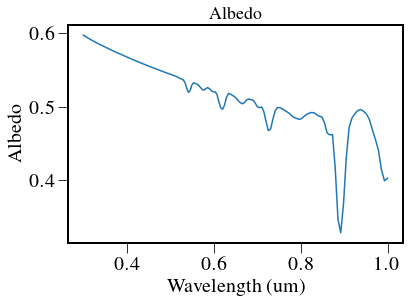

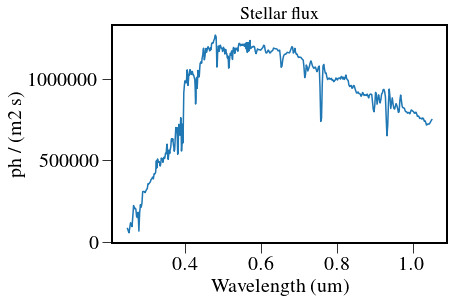

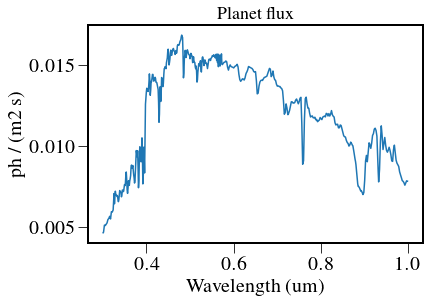

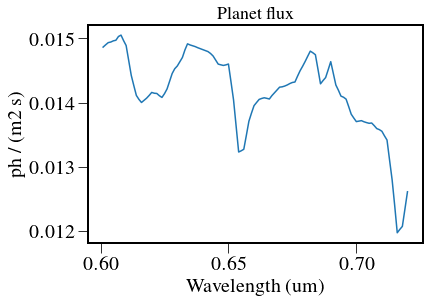

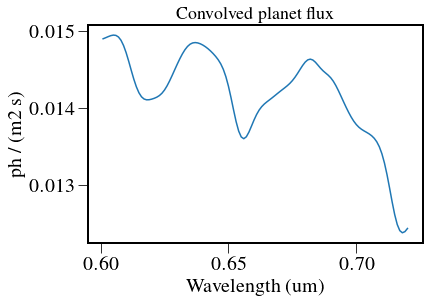

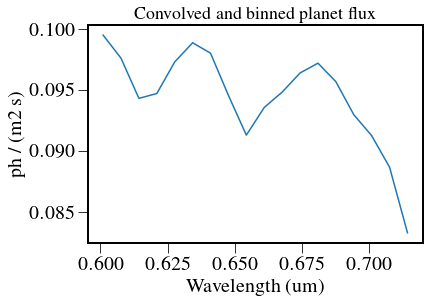

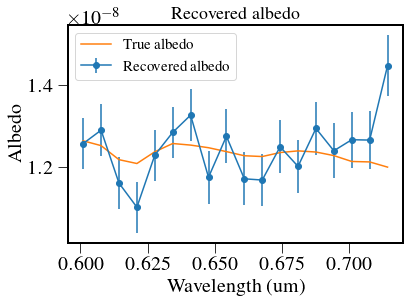

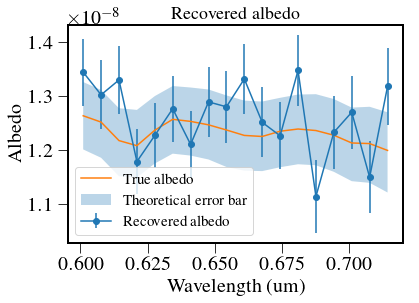

In [6]:
output = IFSModel(par.codeRoot+"/Inputs/LAS_spectra_for_exospec_bright_comparison_0deg_g0.0_EDC_012618_by_SRH.txt",
             minlam=600*u.nm,
             maxlam=721*u.nm,
             Vmag = 4.83,
             R=50,
             QEfile=par.codeRoot+"/QE_CCD201.txt",
             QELosses = 0.9*0.97*0.9*0.81, # losses on top of QE
             verbose=True,
             cic=2e-2*u.ct, # CIC
             dark = 2.24e-4*u.ct/u.s, # dark current
             zodi = 1.1e-3*u.ct/u.s, # total zodiacal contribution
             CFcontrast = 2.2e-9,
             I_pk = 1.4e-3,
             mpix=20, # Noise equivalent pixels
             nbins=18,
             cgi_mpix=32, # used for speckle estimates (will ask Bijan)
             sp_tau = 0.34, # speckle throughput
             tau=0.0144, # planet throughput
             A = 3.68*u.m**2, # aperture size
             mult=1.32,
             fpp=0.1,
             ftime = 100*u.s,
             obstime=240*3600*u.s,
             forceSNR=None,#10,
             ntrials = 1000,)
np.savetxt("/Users/mrizzo/Downloads/660.txt",output.T)